In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import numpy as np
import cv2
from skimage import io, color
from skimage.transform import resize
import shutil

%matplotlib inline

import sys
print(sys.version)
print(sys.executable)

import math
from PIL import Image, ImageDraw, ImageColor
import json
import glob
import os
import cv2
import nibabel as nib

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
c:\ProgramData\Anaconda3\python.exe


## Define Methods:

In [2]:
# draw dicom images with metadata info
from datetime import datetime
def drawCategorizedImages(folderPath, dict, fontsize=10, fontfamily='MingLiU'):
    for patient in dict:
        for study in dict[patient]:
            for series in dict[patient][study]:
                fileList = dict[patient][study][series]
                imagesList = []
                for file in fileList:
                    imagesList.append(dcmread(folderPath + file['dcmPath']))
                imagesList.sort(key=lambda x: x.InstanceNumber, reverse=False) # sort image by instance number
                quantity = len(imagesList)
                cols = 10
                rows = math.ceil(quantity/cols)
                rows = rows + int(rows/6) + 1 # add blank rows to place text
                fig = plt.figure(figsize=(cols*2,rows*2))
                flag = True
                for i in range(quantity):
                    ds = imagesList[i]

                    if ("PixelData" in ds):
                        #add text only once
                        if flag:
                            plt.text(0.01,0.14,"PatientName: " + str(ds.PatientName), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.11,"PatientID: " + str(ds.PatientID), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.08,"Sex: " + str(ds.PatientSex), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.14,"InstitutionName: " + ds.InstitutionName if ds.InstitutionName != "" else "InstitutionName: None", fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.11,"StudyDescription: " + ds.StudyDescription, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.08,"StudyID: " + ds.StudyID, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.14,"SeriesNumber: " + str(ds.SeriesNumber), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.11,"SeriesDescription: " + str(ds.SeriesDescription), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.08,"AccessionNumber: " + ds.AccessionNumber, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.05,"AcquisitionDate: " + str(datetime.strptime(ds.AcquisitionDate, '%Y%m%d').date()), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.02,"AcquisitionTime: " + ds.AcquisitionTime, fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.085,"SliceThickness: " + str(math.ceil(ds.SliceThickness)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.06,"SliceLocation: " + str(math.ceil(ds.SliceLocation)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
                            flag = False   

                        fig.add_subplot(rows, cols, i+1)
                        if(len(ds.pixel_array.shape)==3):
                            plt.imshow(ds.pixel_array[:,:,1])
                        else:
                            plt.imshow(ds.pixel_array)
                        plt.axis('off')

##################################################################

def showImagesWithPyPlot(images,cmap):
    quantity = len(images)
    cols = 9
    rows = math.ceil(quantity/cols)
    fig,ax = plt.subplots(rows,cols,figsize=(22,2.5*rows))
    for i in range(quantity):
        ax[i//cols][i%cols].imshow(images[i],cmap=cmap)
        ax[i//cols][i%cols].axis('off')

def showNiftiImagesWithPyPlot(nifti,cmap):
    quantity = nifti.shape[2]
    cols = 9
    rows = math.ceil(quantity/cols)
    fig,ax = plt.subplots(rows,cols,figsize=(22,2.5*rows))
    for i in range(quantity):
        ax[i//cols][i%cols].imshow(nifti[:,:,i],cmap=cmap)
        ax[i//cols][i%cols].axis('off')

##################################################################

#使用json檔案畫實心標記區域
def fillMissingPoint(segments):
    startX = segments[0]['a'][0]
    startY = segments[0]['a'][1]
    endX = segments[len(segments)-1]['b'][0]
    endY = segments[len(segments)-1]['b'][1]
    width = segments[0]['width']
    distanceX = abs(endX-startX)
    distanceY = abs(endY-startY)    
    stepX = 1
    if(distanceX<=distanceY and distanceY!=0):
        stepX = distanceX/distanceY
    stepY = 1
    if(distanceY<=distanceX and distanceX!=0):
        stepY = distanceY/distanceX
    if(endX >= startX and endY >= startY):
        while(endX >= startX and endY >= startY):
            a = [endX,endY]
            endX-=stepX
            endY-=stepY
            b = [endX,endY]
            segments.append({'a':a,'b':b,'width':width})
    elif(endX >= startX and endY <= startY):
        while(endX >= startX and endY <= startY):
            a = [endX,endY]
            endX-=stepX
            endY+=stepY
            b = [endX,endY]
            segments.append({'a':a,'b':b,'width':width})
    elif(endX <= startX and endY <= startY):
        while(endX <= startX and endY <= startY):
            a = [endX,endY]
            endX+=stepX
            endY+=stepY
            b = [endX,endY]
            segments.append({'a':a,'b':b,'width':width})
    elif(endX <= startX and endY >= startY):
        while(endX <= startX and endY >= startY):
            a = [endX,endY]
            endX+=stepX
            endY-=stepY
            b = [endX,endY]
            segments.append({'a':a,'b':b,'width':width})
    return segments

def getLabeledImageWithJson(jsonPath):
    file = open(jsonPath)
    data = json.load(file)
    image = Image.new("RGB", data['size'])
    draw = ImageDraw.Draw(image)
    shapes = data['shapes']
    for shape in shapes:
        segments = shape['segments']
        segments = fillMissingPoint(segments)
        strokeColor = shape['strokeColor']
        for segment in segments:
            startEndCoord = [(segment['a'][0], segment['a'][1]),(segment['b'][0], segment['b'][1])]
            draw.line(startEndCoord, fill=strokeColor)
    
    # 找輪廓並填充顔色
    grayImage  = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
    cnts = cv2.findContours(grayImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(grayImage,[c], 0, (255,255,255), -1)

    colorImage = cv2.cvtColor(grayImage,cv2.COLOR_GRAY2RGB)
    colorImage[np.all(colorImage == (255, 255, 255), axis=-1)] = ImageColor.getcolor(strokeColor, "RGB")    
    
    #convert black background to transparent
    _, alpha = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(colorImage)
    rgba = [b, g, r, alpha]
    colorImage = cv2.merge(rgba, 4)
    
    #convert cv2 to pil format
    pilImage = Image.fromarray(colorImage)
    return pilImage

##################################################################

# categorize dicom files with patientID, studyID and seriesID without using dicomdir
# 查找自己的json標記檔是否存在，如果不存在label設爲no，否則label設爲json標記檔的路徑
def getLabelPath(dcmPath, sopInstanceUID):
    jsonFiles = glob.glob(dcmPath.split('\\')[0] + "/*.json")
    for jsonFile in jsonFiles:
        if(sopInstanceUID in jsonFile):
            return jsonFile
    return 'NA'

# dict: {patientID->studyID->seriesID->{dcmPath,labelPath}}
def getCategorizedDictByFolder(path):
    files = glob.glob(path + "*.dcm")
    dict = {}
    for file in files:
        ds = dcmread(file)
        patientID = ds.PatientID
        studyID = ds.StudyID
        seriesID = str(ds.SeriesNumber)
        labelPath = getLabelPath(file, ds.SOPInstanceUID)
        data = {'dcmPath':file,'labelPath':labelPath}
        if patientID in dict:
            if studyID in dict[patientID]:
                if seriesID in dict[patientID][studyID]:
                    dict[patientID][studyID][seriesID].append(data)
                else:
                    dict[patientID][studyID][seriesID] = [data]
            else:
                dict[patientID][studyID] = {seriesID:[data]}
        else:
            dict[patientID] = {studyID:{seriesID:[data]}}

    # sort dict by InstanceNumber
    for patient in dict:
            for study in dict[patient]:
                for series in dict[patient][study]:
                    dict[patient][study][series].sort(key=lambda x: dcmread(x['dcmPath']).InstanceNumber, reverse=False)

    return dict

def getSeriesIDByName(dict, name):
    for patient in dict:
        for study in dict[patient]:
            for series in dict[patient][study]:
                for i in dict[patient][study][series]:
                    if(name.lower() in dcmread(i['dcmPath']).SeriesDescription.lower()):
                        return series
##################################################################

# 調整圖像色階
def adjust_color_scale(img,Shadow,Highlight):
    if Highlight > 255:
        Highlight = 255
    if Shadow < 0:
        Shadow = 0
    if Shadow >= Highlight:
        Shadow = Highlight - 2
    # 转类型
    img = np.array(img, dtype=int)
    # 计算白场黑场离差
    Diff = Highlight - Shadow
    # 计算系数
    coe = 255.0 / Diff
    rgbDiff = img - Shadow
    rgbDiff = np.maximum(rgbDiff, 0)
    img = rgbDiff * coe
    # 四舍五入到整数
    img = np.around(img, 0)
    # 变为int型
    img = img.astype(np.uint8)
    return img

##################################################################

# 計算兩張圖片的相似度（https://www.twblogs.net/a/5ee8804f38b2869e41a03399）

# 均值哈希算法
def aHash(img):
    # 縮放爲8*8
    img = cv2.resize(img, (8, 8))
    # 轉換爲灰度圖
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # s爲像素和初值爲0，hash_str爲hash值初值爲''
    s = 0
    hash_str = ''
    # 遍歷累加求像素和
    for i in range(8):
        for j in range(8):
            s = s + gray[i, j]
    # 求平均灰度
    avg = s / 64
    # 灰度大於平均值爲1相反爲0生成圖片的hash值
    for i in range(8):
        for j in range(8):
            if gray[i, j] > avg:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str
# 差值感知算法
def dHash(img):
    img = cv2.resize(img, (9, 8))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''
    # 每行前一個像素大於後一個像素爲1，相反爲0，生成哈希
    for i in range(8):
        for j in range(8):
            if gray[i, j] > gray[i, j + 1]:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str
# 感知哈希算法(pHash)
def pHash(img):
    img = cv2.resize(img, (32, 32))  # , interpolation=cv2.INTER_CUBIC
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 將灰度圖轉爲浮點型，再進行dct變換
    dct = cv2.dct(np.float32(gray))
    # opencv實現的掩碼操作
    dct_roi = dct[0:8, 0:8]

    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash
# Hash值對比
def cmpHash(hash1, hash2):
    n = 0
    # hash長度不同則返回-1代表傳參出錯
    if len(hash1)!=len(hash2):
        return -1
    # 遍歷判斷
    for i in range(len(hash1)):
        # 不相等則n計數+1，n最終爲相似度
        if hash1[i] != hash2[i]:
            n = n + 1
    return n

##################################################################

# interpolating between two images
import matplotlib.cm as cm
from scipy import interpolate
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import shift

def inter(images,t):
    # input: 
    # images: list of arrays/frames ordered according to motion
    # t: parameter ranging from 0 to 1 corresponding to first and last frame 
    # returns: interpolated image

    #direction of movement, assumed to be approx. linear 
    a=np.array(center_of_mass(images[0]))
    b=np.array(center_of_mass(images[-1]))

    #find index of two nearest frames
    arr=np.array([center_of_mass(images[i]) for i in range(len(images))])
    v=a+t*(b-a) #convert t into vector 
    idx1 = (np.linalg.norm((arr - v),axis=1)).argmin()
    arr[idx1]=np.array([0,0]) #this is sloppy, should be changed if relevant values are near [0,0]
    idx2 = (np.linalg.norm((arr - v),axis=1)).argmin()

    if idx1>idx2:
        b=np.array(center_of_mass(images[idx1])) #center of mass of nearest contour
        a=np.array(center_of_mass(images[idx2])) #center of mass of second nearest contour
        tstar=np.linalg.norm(v-a)/np.linalg.norm(b-a) #define parameter ranging from 0 to 1 for interpolation between two nearest frames
        im1_shift=shift(images[idx2],(b-a)*tstar) #shift frame 1
        im2_shift=shift(images[idx1],-(b-a)*(1-tstar)) #shift frame 2
        return im1_shift+im2_shift #return average

    if idx1<idx2:
        b=np.array(center_of_mass(images[idx2]))
        a=np.array(center_of_mass(images[idx1]))
        tstar=np.linalg.norm(v-a)/np.linalg.norm(b-a)
        im1_shift=shift(images[idx2],-(b-a)*(1-tstar))
        im2_shift=shift(images[idx1],(b-a)*(tstar))
        return im1_shift+im2_shift


##################################################################

# convert dicom's pixel array to image looks like what we see on standard DICOM viewers
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut

def get_LUT_value_LINEAR_EXACT(data, window, level):
    """
    Adjust according to VOI LUT, window center(level) and width values
    not normalized
    """
    data_min = data.min()
    data_max = data.max()
    data_range = data_max - data_min
    data = np.piecewise(data, 
        [data<=(level-(window)/2),
        data>(level+(window)/2)],
        [data_min, data_max, lambda data: ((data-level+window/2)/window*data_range)+data_min])
    return data

def pixel_process(ds, pixel_array):
    """
    Process the images
    input image info and original pixeal_array
    applying LUTs: Modality LUT -> VOI LUT -> Presentation LUT    
    return processed pixel_array, in 8bit; RGB if color
    """
    
    ## LUTs: Modality LUT -> VOI LUT -> Presentation LUT
    # Modality LUT, Rescale slope, Rescale Intercept
    if 'RescaleSlope' in ds and 'RescaleIntercept' in ds:
        # try applying rescale slope/intercept
        # cannot use INT, because rescale slope could be<1 
        rescale_slope = float(ds.RescaleSlope) # int(ds.RescaleSlope)
        rescale_intercept = float(ds.RescaleIntercept) #  int(ds.RescaleIntercept)
        pixel_array = (pixel_array) * rescale_slope + rescale_intercept
    else:
        # otherwise, try to apply modality 
        pixel_array = apply_modality_lut(pixel_array, ds)


    # personally prefer sigmoid function than window/level
    # personally prefer LINEAR_EXACT than LINEAR (prone to err if small window/level, such as some MR images)
    if 'VOILUTFunction' in ds and ds.VOILUTFunction=='SIGMOID':
        pixel_array = apply_voi_lut(pixel_array, ds)
    elif 'WindowCenter' in ds and 'WindowWidth' in ds:
        window_center = ds.WindowCenter
        window_width = ds.WindowWidth
        # some values may be stored in an array
        if type(window_center)==pydicom.multival.MultiValue:
            window_center = float(window_center[0])
        else:
            window_center = float(window_center)
        if type(window_width)==pydicom.multival.MultiValue:
            window_width = float(window_width[0])
        else:
            window_width = float(window_width)
        pixel_array = get_LUT_value_LINEAR_EXACT(pixel_array, window_width, window_center)
    else:
        # if there is no window center, window width tag, try applying VOI LUT setting
        pixel_array = apply_voi_lut(pixel_array, ds)
        
    # Presentation VOI
    # normalize to 12 bit
    pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min()))
    # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
    if 'PhotometricInterpretation' in ds and ds.PhotometricInterpretation == "MONOCHROME1":
        # NOT add minus directly
        pixel_array = np.max(pixel_array) - pixel_array
    
    # conver float -> 12-bit
    return pixel_array.astype('float')

##################################################################

# Image shadow and highlight correction
def imageCorrection(
        img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent
):
    """
    Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
    :param img: input RGB image numpy array of shape (height, width, 3)
    :param shadow_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param highlight_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param color_percent [-1.0 ~ 1.0]:
    :return:
    """
    shadow_tone = shadow_tone_percent * 255
    highlight_tone = 255 - highlight_tone_percent * 255

    shadow_gain = 1 + shadow_amount_percent * 6
    highlight_gain = 1 + highlight_amount_percent * 6

    # extract RGB channel
    height, width = img.shape[:2]
    img = img.astype(np.float)
    img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)

    # The entire correction process is carried out in YUV space,
    # adjust highlights/shadows in Y space, and adjust colors in UV space
    # convert to Y channel (grey intensity) and UV channel (color)
    img_Y = .3 * img_R + .59 * img_G + .11 * img_B
    img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
    img_V = img_R * .5 - img_G * .418688 - img_B * .081312

    # extract shadow / highlight
    shadow_map = 255 - img_Y * 255 / shadow_tone
    shadow_map[np.where(img_Y >= shadow_tone)] = 0
    highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
    highlight_map[np.where(img_Y <= highlight_tone)] = 0

    # // Gaussian blur on tone map, for smoother transition
    if shadow_amount_percent * shadow_radius > 0:
        # shadow_map = cv2.GaussianBlur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), sigmaX=0).reshape(-1)
        shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius)).reshape(-1)

    if highlight_amount_percent * highlight_radius > 0:
        # highlight_map = cv2.GaussianBlur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius), sigmaX=0).reshape(-1)
        highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius)).reshape(-1)

    # Tone LUT
    t = np.arange(256)
    LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
    LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
    LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
    LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))

    # adjust tone
    shadow_map = shadow_map * (1 / 255)
    highlight_map = highlight_map * (1 / 255)

    iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
    iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
    img_Y = iH

    # adjust color
    if color_percent != 0:
        # color LUT
        if color_percent > 0:
            LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
        else:
            LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1

        # adjust color saturation adaptively according to highlights/shadows
        color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
        w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
        img_U = w * img_U + (1 - w) * img_U * color_gain
        img_V = w * img_V + (1 - w) * img_V * color_gain

    # re convert to RGB channel
    output_R = np.int_(img_Y + 1.402 * img_V + .5)
    output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
    output_B = np.int_(img_Y + 1.772 * img_U + .5)

    output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
    output = np.minimum(output, 255).astype(np.uint8)
    return output

##################################################################

# Rescale array
def rescaleFrom0to255(arr):
    min_val = arr.min()
    max_val = arr.max()

    # Rescale the array
    arr_rescaled = (arr - min_val) * (255 - 0) / (max_val - min_val) + 0
    return arr_rescaled.astype(np.uint8)

# Rescale array
def rescaleFrom0to1(arr):
    min_val = arr.min()
    max_val = arr.max()

    # Rescale the array
    arr_rescaled = (arr - min_val) * (1 - 0) / (max_val - min_val) + 0
    return arr_rescaled

##################################################################

# applu CT window
def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1
    return R

# enlarge image layout
def enlargeImageLayout(input,outputSize):
    size = input.shape
    output = np.zeros((outputSize))
    startX = outputSize[0]//2 - size[0]//2
    startY = outputSize[1]//2 - size[1]//2
    output[startX:startX+size[0],startY:startY+size[1]] = input
    return output

## Dicom Categorizing：

In [8]:
# 按照series對MRI與PET做資料夾分類，並使用json檔案生成MRI對應的label圖像
for i in range(10,23):
    patientNo = str(i).zfill(3)
    mri_dict = getCategorizedDictByFolder('./20230628/PT_MR/'+ patientNo+ '/MR/')
    pet_dict = getCategorizedDictByFolder('./20230628/PT_MR/'+ patientNo+ '/PT/')

    for patient in mri_dict:
        for study in mri_dict[patient]:
            for series in mri_dict[patient][study]:
                seriesDescripiton = dcmread(mri_dict[patient][study][series][0]['dcmPath']).SeriesDescription
                seriesDescripiton = seriesDescripiton.replace('/',' ')
                seriesDescripiton = seriesDescripiton.replace('*','')
                path = 'categorized/20230628/'+ patientNo+ '/MRI/'+ series + ' (' + seriesDescripiton + ')'
                labelPath = 'categorized/20230628/'+ patientNo+ '/MRI/'+ series + ' (' + seriesDescripiton + ')' + '/label/'
                if not os.path.exists(path):
                    os.makedirs(path)
                if not os.path.exists(labelPath):
                    os.makedirs(labelPath)
                for c,v in enumerate(mri_dict[patient][study][series]):
                    shutil.copy(v['dcmPath'],path+ '/'+ str(c+1).zfill(3)+ '.dcm')
                    width = dcmread(v['dcmPath']).pixel_array.shape[0]
                    height = dcmread(v['dcmPath']).pixel_array.shape[1]
                    labelImg = Image.new('RGBA', (width, height))
                    if(v['labelPath']!='NA'):                    
                        labelImg = getLabeledImageWithJson(v['labelPath'])
                    labelImg.save(labelPath + str(c+1).zfill(3) + '.png')
                    
    for patient in pet_dict:
        for study in pet_dict[patient]:
            for series in pet_dict[patient][study]:
                seriesDescripiton = dcmread(pet_dict[patient][study][series][0]['dcmPath']).SeriesDescription
                seriesDescripiton = seriesDescripiton.replace('/',' ')
                path = 'categorized/20230628/'+ patientNo+ '/PET/'+ series + ' (' + seriesDescripiton + ')'
                if not os.path.exists(path):
                    os.makedirs(path)
                for c,v in enumerate(pet_dict[patient][study][series]):
                    shutil.copy(v['dcmPath'],path+ '/'+ str(c+1).zfill(3)+ '.dcm')

In [240]:
# 複製每個病人的MRI、CT、PETCT到corresponded資料夾（準備對應工作）

def find_with_substring(arr, substring):
    for string in arr:
        if substring in string:
            return string
    return None

mriWithLabelList = [ 'dark-fluid','FLAIR','dark-fluid','FLAIR','FLAIR',
                    'dark-fluid','dark-fluid','dark-fluid','dark-fluid','t1_fl2d_tra',
                    'TRA_T1W_3D','FLAIR','T1W_tra','t1_fl2d_tra_fs','FLAIR',
                    'FLAIR','FLAIR','dark-fluid','FLAIR','dark-fluid',
                    'FLAIR','dark-fluid','dark-fluid','t1_fl2d_tra','dark-fluid',
                    't1_fl2d_tra_fs','t1_fl2d_tra_fs','t1_fl2d_tra_fs','T1W_TRA' ]

for i in range(1,30):
    patientNo = str(i).zfill(3)

    mriDir = './categorized/20230209/'+patientNo+'/MRI/'
    mriDir = mriDir+find_with_substring(os.listdir(mriDir), mriWithLabelList[i-1])
    mris = glob.glob(mriDir+'/*.dcm')
    labels = glob.glob(mriDir+'/label/'+'*.png')

    ctDir = './categorized/20230209/'+patientNo+'/PET/'
    ctDir = ctDir+find_with_substring(os.listdir(ctDir),'WB ')
    cts = glob.glob(ctDir+'/*.dcm')

    petctDir = './categorized/20230209/'+patientNo+'/PET/'
    petctDir = petctDir+find_with_substring(os.listdir(petctDir),'Axial')
    petcts = glob.glob(petctDir+'/*.dcm')

    for j in range(len(mris)):        
        dstMriDir = './corresponded/20230209/'+patientNo+'/MRI/'
        dstLabelDir = './corresponded/20230209/'+patientNo+'/label/'

        if not os.path.exists(dstMriDir):
            os.makedirs(dstMriDir)
        if not os.path.exists(dstLabelDir):
            os.makedirs(dstLabelDir)        
        
        shutil.copy(mris[j],dstMriDir)
        shutil.copy(labels[j],dstLabelDir)

    for j in range(70):
        dstCtDir = './corresponded/20230209/'+patientNo+'/CT/'
        dstPetctDir = './corresponded/20230209/'+patientNo+'/PETCT/'

        if not os.path.exists(dstCtDir):
            os.makedirs(dstCtDir)
        if not os.path.exists(dstPetctDir):
            os.makedirs(dstPetctDir)
            
        shutil.copy(cts[j],dstCtDir)
        shutil.copy(petcts[j],dstPetctDir)

In [86]:
# dicom格式轉換成png
import dicom2jpg
for i in range(5,6):
    mriDicomFolder = './corresponded/20230209/'+str(i).zfill(3)+'/MRI/'
    dicom2jpg.dicom2png(mriDicomFolder, target_root=mriDicomFolder)
    mriDicomFolder = './corresponded/20230209/'+str(i).zfill(3)+'/CT/'
    dicom2jpg.dicom2png(mriDicomFolder, target_root=mriDicomFolder)
    mriDicomFolder = './corresponded/20230209/'+str(i).zfill(3)+'/PETCT/'
    dicom2jpg.dicom2png(mriDicomFolder, target_root=mriDicomFolder)

In [47]:
# 移動轉換png后的圖片到跟dicom同一個目錄的png目錄下，並重新按照順序命名

#找不是.dcm的文件夾名稱
def find_folder_name(arr, substring):
    for string in arr:
        if substring not in string:
            return string
    return None

def doit(mode):
    for i in range(2,30):
        patientNo = str(i).zfill(3)
        rootDir = './corresponded/20230209/'+patientNo+'/'+mode+'/'
        rootDir = rootDir + find_folder_name(os.listdir(rootDir),'.dcm') + '/'
        toDeleteFolder = rootDir
        rootDir = rootDir + os.listdir(rootDir)[0] + '/'
        rootDir = rootDir + os.listdir(rootDir)[0] + '/'
        pngs = glob.glob(rootDir+'*.png')
        pngs.sort(key=lambda x: len(x), reverse=False)
        renameFolder = './corresponded/20230209/'+patientNo+'/'+mode+'/png/'
        if not os.path.exists(renameFolder):
            os.makedirs(renameFolder)
        for c,v in enumerate(pngs):
            os.rename(v, renameFolder + str(c+1).zfill(3) + '.png')
        shutil.rmtree(toDeleteFolder)

doit('CT')
doit('MRI')
doit('PETCT')

In [199]:
# rename files (因轉換後檔案名稱在排序上有問題，需要重新命名)
for i in range(29):
    startNum = 1
    renameFolder = './corresponded/20230209/'+str(i+1).zfill(3)+'/CT/'
    files = glob.glob(renameFolder + "*.png")
    files.sort(key=lambda x: len(x), reverse=False)
    for c,v in enumerate(files):
        os.rename(v, renameFolder + str(c+startNum).zfill(3) + '.png')

## Preprocessing of Image Registration:

In [157]:
patientNo = '029'
mriPath = './corresponded/20230209/'+patientNo+'/MRI/'
ctPath = './corresponded/20230209/'+patientNo+'/CT/'

In [160]:
# 計算MRI與PET之間的voxel物理大小 與 兩者之間的縮放比例
mri = dcmread(mriPath + '001.dcm')
ct = dcmread(ctPath + '001.dcm')
petctPixelRatio = ct.pixel_array.shape[0]/824
mriPixelSpacing = mri.PixelSpacing
ctPixelSpacing = ct.PixelSpacing
# pixelRatio = ct.pixel_array.shape[0]/mri.pixel_array.shape[0]
physicalRatio = ctPixelSpacing[0]/mriPixelSpacing[0]
rescaleRatio = physicalRatio * petctPixelRatio # petctPixelRatio（ct與petct的解析度比例，調整一樣的解析度后内容大小一樣） / scalar->ex:0.87（ct與petct的内容大小比例）
print(mri.pixel_array.shape)
print('MRI: ' + str(mriPixelSpacing))
print(ct.pixel_array.shape)
print('CT: ' + str(ctPixelSpacing))
print('Ratio: ' + str(rescaleRatio))

(512, 512)
MRI: [0.44921875, 0.44921875]
(512, 512)
CT: [1.367188, 1.367188]
Ratio: 1.8910939799071338


In [4]:
# 對圖片矩陣進行翻轉/旋轉至原本的狀態（3D slicer輸出的nii會導致圖片翻轉）,並調整成240*240*48
dir = glob.glob('./petct_training_dataset/*.nii.gz')
for ds in dir:
    petct_nii = nib.load(ds).get_fdata()
    result = np.zeros((240,240,48))
    for i in range(48):
        if(i<petct_nii.shape[2]):
            result[:,:,i] = cv2.resize(np.fliplr(np.rot90(petct_nii[:,:,i],3)),(240,240))
    nib.save(nib.Nifti1Image(result, affine=np.eye(4)), ds)

In [ ]:
#plot comparison between MRI and registered PETCT
patientNo = '003'
mris = nib.load('./mri_training_dataset/size_fixed/0_'+patientNo+'.nii.gz').get_fdata()
labels = nib.load('./petct_training_dataset/size_fixed/0_'+patientNo+'_seg.nii.gz').get_fdata()
petcts = nib.load('./petct_training_dataset/size_fixed/0_'+patientNo+'.nii.gz').get_fdata()
cols = 3
rows = 48
fig = plt.figure(figsize=(6, 100))
for n_slice in range(rows):
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+1)
    ax.set_title('mri')
    plt.imshow(mris[:,:,n_slice],cmap='gray')
    plt.axis('off')
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+2)
    ax.set_title('petct')
    plt.imshow(petcts[:,:,n_slice],cmap='gray')
    plt.axis('off')
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+3)
    ax.set_title('label')
    plt.imshow(labels[:,:,n_slice])
    plt.axis('off')

In [ ]:
#superimpose label to mri and petct then save image
patientNo = '015'
correspondedMRIPaths = glob.glob('corresponded/20230209/'+patientNo+'/MRI/png/*.png')
correspondedLabelPaths = glob.glob('corresponded/20230209/'+patientNo+'/label/contour/*.png')
petcts = nib.load('./petct_training_dataset/20230209/'+patientNo+'.nii.gz').get_fdata()
cols = 2
rows = petcts.shape[2]
fig = plt.figure(figsize=(20,10))
for n_slice in range(rows):
    mri = Image.open(correspondedMRIPaths[n_slice])
    label = Image.open(correspondedLabelPaths[n_slice])
    petct = Image.fromarray(petcts[:,:,n_slice])
    mri.paste(label,(0,0),mask=label)
    petct.paste(label,(0,0),mask=label)
    ax=fig.add_subplot(1,cols,1)
    ax.set_title("MRI",fontsize=22)
    plt.imshow(mri,cmap='gray')
    plt.axis('off')
    ax=fig.add_subplot(1,cols,2)
    ax.set_title("PETCT",fontsize=22)
    plt.imshow(np.array(petct),cmap='hot')
    plt.axis('off')
    plt.savefig(str(n_slice+1).zfill(3) + '.jpg')

In [ ]:
# prepare 1-channel mri(flair or dark_fluid) for training:
for i in range(1,30):
    patientNo = str(i).zfill(3)
    mriDir = glob.glob('corresponded/20230209/'+patientNo+'/mri/png/*.png')
    size = io.imread(mriDir[0]).shape[0]
    result = np.zeros((size,size,len(mriDir)))
    for i in range(len(mriDir)):
        mri = io.imread(mriDir[i])
        result[:,:,i] = mri
    nib.save(nib.Nifti1Image(result, affine=np.eye(4)), './mri_training_dataset/1_'+patientNo+'_mri.nii.gz')

In [18]:
# prepare label for training:
for i in range(14,15):
    patientNo = str(i).zfill(3)
    labelDir = glob.glob('corresponded/20230209/'+patientNo+'/label/*.png')
    label_res = np.zeros((240,240,48))
    for i in range(len(labelDir)):
        if(i<48):
            label_res[:,:,i] = cv2.resize(io.imread(labelDir[i]),(240,240))
    nib.save(nib.Nifti1Image(label_res, affine=np.eye(4)), './petct_training_dataset/1_'+patientNo+'_seg.nii.gz')

In [8]:
# change petct and label to the same size (240*240*48)
petctDir = glob.glob('./petct_training_dataset/*.nii.gz')
size = 240
depth = 48
for i in petctDir:    
    result = np.zeros((size,size,depth))
    nii = nib.load(i).get_fdata()
    for j in range(depth):
        if(j<nii.shape[2]):
            result[:,:,j] = resize(nii[:,:,j],(size,size),anti_aliasing=False)
    nib.save(nib.Nifti1Image(result, affine=np.eye(4)), './petct_training_dataset/size_fixed_128/'+i.split('\\')[1])

In [17]:
# rescale nii label value from range of 0 to 1
petctDir = glob.glob('./petct_training_dataset/*seg.nii.gz')
for i in petctDir:
    nii = nib.load(i).get_fdata()
    nii[nii<127] = 0
    nii[nii>=127] = 1
    nib.save(nib.Nifti1Image(nii, affine=np.eye(4)), i)

## Image Fusing:

In [138]:
# Image Fusing for PET and CT
patient_id = str(400).zfill(3)
saveDir = './petct_training_dataset/fused/'
ct = nib.load(f'./petct_training_dataset/registrated/{patient_id}_ct.nii.gz').get_fdata()
pet = nib.load(f'./petct_training_dataset/registrated/{patient_id}_pet.nii.gz').get_fdata()
res = np.zeros((256,256,ct.shape[2]))
print(ct.shape)
print(pet.shape)
xs = 115
ys = 80
for i in range(ct.shape[2]):
    alpha = 0.5
    beta = 1 - alpha
    fused = cv2.addWeighted(apply_ct_window(ct[:,:,i],(300,40)),alpha,rescaleFrom0to1(pet[:,:,i]),beta,0.0)
    res[:,:,i] = fused[xs:xs+256,ys:ys+256]
nib.save(nib.Nifti1Image(res, affine=np.eye(4)), saveDir + f'{patient_id}_petct.nii.gz')

(512, 512, 64)
(512, 512, 64)


In [144]:
#save petct and label to nii for training
from skimage.transform import resize
patientNum = '015'
petcts = glob.glob('../dataset/PETCT/NoTumorInBrian/'+patientNum+'/petct/*.png')
# labels = glob.glob('../dataset/PETCT/NoTumorInBrian/'+patientNum+'/label/*.png')
imgSize = 128
slicesNum = 48
petct = np.zeros((imgSize,imgSize,slicesNum))
seg = np.zeros((imgSize,imgSize,slicesNum))
for i in range(slicesNum):
    if(i>=len(petcts)):
        petct[:,:,i] = np.zeros((imgSize,imgSize))
        seg[:,:,i] = np.zeros((imgSize,imgSize))
    else:
        img = io.imread(petcts[i])
        # label = io.imread(labels[i])[:,:]
        # print(np.unique(label))
        # if(img.shape[0]>imgSize):
        #     img = rescaleFrom0to255(resize(img,(imgSize,imgSize)))
        # if(label.shape[0]>imgSize):
        #     label = rescaleFrom0to255(resize(label,(imgSize,imgSize)))
        petct[:,:,i] = img
        # seg[:,:,i] = label
seg[seg!=0] = 1
nib.save(nib.Nifti1Image(petct, affine=np.eye(4)), 'pet_training_dataset/FDG/' + patientNum + '_pet.nii.gz')
nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), 'pet_training_dataset/FDG/' + patientNum + '_pet_seg.nii.gz')

In [ ]:
# validate saved pet nib (compare with original mri)
patientNum = '003'
mri = glob.glob('./corresponded/'+patientNum+'/shaped/*.png')
pet = nib.load('../U-net/pet_training_dataset/'+patientNum+'_pet.nii.gz').get_fdata()
seg = nib.load('../U-net/pet_training_dataset/'+patientNum+'_pet_seg.nii.gz').get_fdata()
print(pet.shape)
print(seg.shape)
print(np.unique(seg))
cols = 3
rows = 48
fig = plt.figure(figsize=(6,100))
for n_slice in range(rows):
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+1)
    plt.imshow(pet[:,:,n_slice],cmap='gray')
    plt.axis('off')
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+2)
    plt.imshow(pet[:,:,n_slice],cmap='gray')
    plt.axis('off')
    ax=fig.add_subplot(rows,cols,(n_slice*cols)+3)
    plt.imshow(seg[:,:,n_slice])
    plt.axis('off')

In [ ]:
## save petct dicom to gray image
dir = './categorized/20221005/001/PET/1353 (FDG WBS PET CT Axial)/'
petct = glob.glob(dir+'*.dcm')
save_dir = dir+'png/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for i in range(70):
    img = dcmread(petct[i]).pixel_array
    img = color.rgb2gray(ds)
    io.imsave(save_dir+str(i+1).zfill(3)+'.png',img)

In [88]:
## 對MRI進行LUT對比度增强后再進行保存成nifti格式
dir = glob.glob('./corresponded/20230209/029/MRI/*.dcm')
result = np.zeros((240,240,48))
for i in range(48):
    if(i<len(dir)):
        ds = dcmread(dir[i])
        img = pixel_process(ds,ds.pixel_array)
        result[:,:,i] = cv2.resize(img,(240,240))
nib.save(nib.Nifti1Image(result, affine=np.eye(4)), '1_029_mri.nii.gz')

## Preparing nifti for training from TCIA_MRI_Dataset:

In [ ]:
# prepare 256x256x64 nii file
root_dir = '../TCIA_MRI_Dataset/'
folders = glob.glob(os.path.join(root_dir,'TCGA*'))
save_dir = './mri_training_dataset/TCIA/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for c,folder in enumerate(folders):
    tifs = glob.glob(os.path.join(folder,'*.tif'))
    mris = []
    for i in tifs:
        if 'mask' not in i:
            mris.append(i)
    mris = sorted(mris, key=lambda x:len(x))[::-1]
    labels = glob.glob(os.path.join(folder,'*mask.tif'))
    labels = sorted(labels, key=lambda x:len(x))[::-1]
    mri_res = np.zeros((256,256,64))
    label_res = np.zeros((256,256,64))
    n = 0
    for i in range(64):
        if(i<len(mris)):
            mri_res[:,:,i] = io.imread(mris[i])[:,:,1]
            label_res[:,:,i] = io.imread(labels[i])
    label_res[label_res==255] = 1
    nib.save(nib.Nifti1Image(mri_res, affine=np.eye(4)), save_dir + folder.split('\\')[-1] + '.nii.gz')
    nib.save(nib.Nifti1Image(label_res, affine=np.eye(4)), save_dir + folder.split('\\')[-1] + '_mask.nii.gz')

## Preparing nifti for normal_mri:

In [ ]:
patient_id = '022'
flair_tag = '501 (C+T2_FLAIR_FS)'
flair_dir = glob.glob(f'./categorized/20230628/{patient_id}/MRI/{flair_tag}/*.dcm')
flair_dir.sort(key=lambda x: len(x))
save_dir = './mri_training_dataset/normal_flair/'
width = dcmread(flair_dir[0]).pixel_array.shape[0]
height = dcmread(flair_dir[0]).pixel_array.shape[1]
depth = len(flair_dir)
mri_res = np.zeros((width,height,depth))
label_res = np.zeros((width,height,depth))
for c,v in enumerate(flair_dir):
    ds = dcmread(v).pixel_array
    mri_res[:,:,c] = ds
nib.save(nib.Nifti1Image(mri_res, affine=np.eye(4)), save_dir +  patient_id + '_mri.nii.gz')
nib.save(nib.Nifti1Image(label_res, affine=np.eye(4)), save_dir + patient_id + '_mask.nii.gz')
io.imshow(mri_res[:,:,10])

## differentiate the image in the first order:

In [ ]:
def adjust_curve(img, control_points):
    # Convert the image to a 1D array to make manipulation easier
    flat_img = img.flatten()

    # Calculate the interpolation function for the curve points
    x, y = zip(*control_points)
    x = np.array(x)
    y = np.array(y)

    # Ensure that the control points are in ascending order
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Interpolate the curve points using numpy.interp
    interpolated_curve = np.interp(flat_img, x_sorted, y_sorted)

    # Reshape the interpolated values back to the original image shape
    adjusted_img = interpolated_curve.reshape(img.shape)

    return adjusted_img.astype(np.uint8)

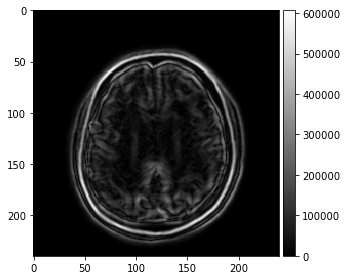

In [95]:
patient = nib.load('./Data/petct_training_dataset/240x240x48/0_001_petct.nii.gz').get_fdata()
img = patient[:,:,15]
gradient_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
gradient_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

gradient_x = np.absolute(gradient_x)
gradient_y = np.absolute(gradient_y)

# 合併x和y方向的梯度
gradient_combined = cv2.addWeighted(gradient_x, 0.5, gradient_y, 0.5, 0)

io.imshow(gradient_combined,cmap='gray')

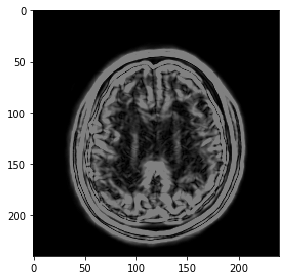

In [102]:
img = rescaleFrom0to255(gradient_combined).astype(np.uint8)

control_points = [
    (0, 0),      # Original dark pixels remain unchanged
    (48, 128),  # Mid-tones are boosted to 50% brightness
    (128, 128),  # Original bright pixels remain unchanged
]

# Perform the curve adjustment
adjusted_img = adjust_curve(img, control_points)

io.imshow(adjusted_img,cmap='gray')